In [ ]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
# Ensure a clean PyTorch installation
!pip uninstall -y torch torchvision
!pip install --no-cache-dir torch torchvision --index-url https://download.pytorch.org/whl/cu121

!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Total 14652 (delta 0), reused 0 (delta 0), pack-reused 14652 (from 1)
Receiving objects: 100% (14652/14652), 21.13 MiB | 16.08 MiB/s, done.
Resolving deltas: 100% (9824/9824), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/

14712527942715592458


  0%|          | 0/20 [00:00<?, ?it/s]

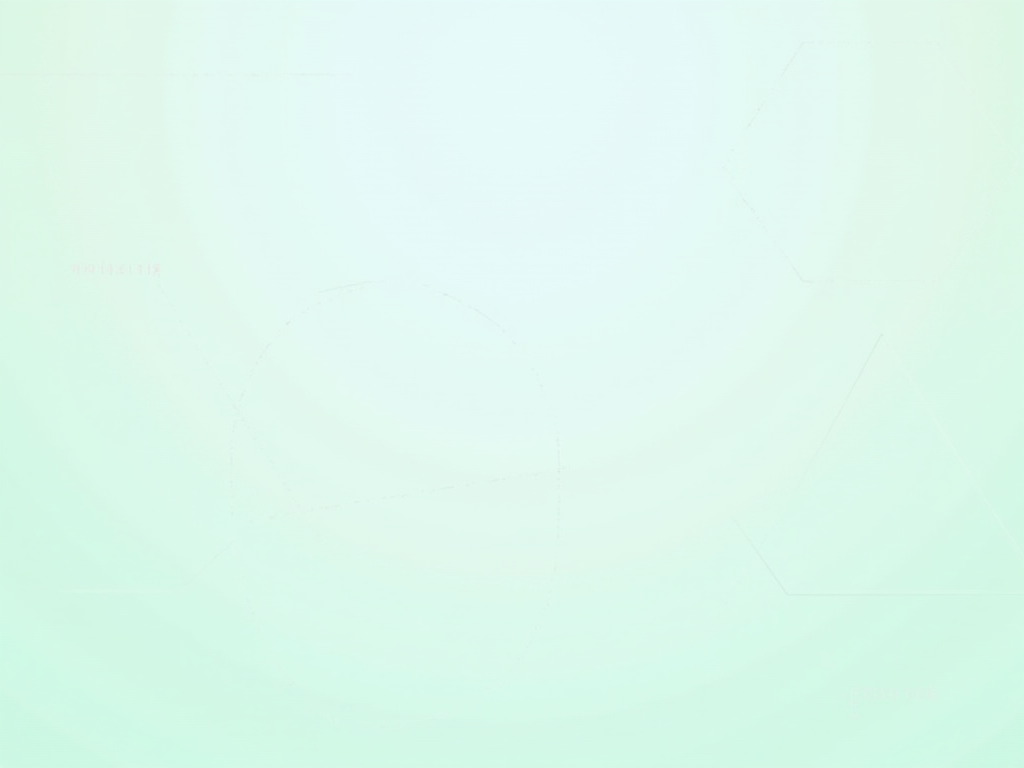

In [ ]:
with torch.inference_mode():
    positive_prompt = '''A clean, educational slide introducing the concept of Perimeter, featuring a variety of simple 2D geometric shapes (square, rectangle, triangle, circle) outlined clearly with dashed or solid borders. Each shape is labeled subtly. A soft ruler or measuring tape is artistically wrapped around or near the shapes to suggest measurement. Background is a smooth light pastel color gradient (light blue, soft peach, mint green, or lavender)'''
    width = 1024
    height = 768
    seed = 0
    steps = 20
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

In [ ]:
import json
from google.colab import files

In [ ]:
file_name = input("Enter the file name: ")

Enter the file name: perimeter


In [ ]:
file_name = f"/content/{file_name}_slides.json"

In [ ]:
with open(file_name, 'r') as f:
    slides_json = json.load(f)

In [ ]:
print(json.dumps(slides_json, indent=4))

{
    "slides": [
        {
            "number": 1,
            "title": "Introduction to Perimeter",
            "details": "Welcome to today's lesson on geometry where we will explore the concept of perimeter.",
            "speakText": "Hello students! Today, we will learn about an important concept in geometry called the perimeter.",
            "transformedSpeakText": "Hello students! Today, we will learn about an important concept in geometry called the perimeter.",
            "image_description": "A colorful illustration of a rectangle with each side labeled with their respective lengths. A friendly cartoon teacher holds a ruler, pointing to one side while smiling and encouraging, \"Let's add these up!\" Soft, pastel-hued clouds float gently in the sky above, creating a cheerful and inviting atmosphere."
        },
        {
            "number": 2,
            "title": "Defining Perimeter",
            "details": "The perimeter of a closed plane figure is the distance travele

In [ ]:
prompts = []
for slide in slides_json["slides"]:
    prompts.append(slide["image_description"])
print(prompts)

['A colorful illustration of a rectangle with each side labeled with their respective lengths. A friendly cartoon teacher holds a ruler, pointing to one side while smiling and encouraging, "Let\'s add these up!" Soft, pastel-hued clouds float gently in the sky above, creating a cheerful and inviting atmosphere.', 'A simple blue rectangle with labels on each side showing their lengths. A cheerful stick figure walks along the perimeter, leaving a trail of glowing footprints. Each side of the rectangle is marked with arrows indicating the direction of travel. Soft, pastel-colored background.', 'A rectangle and a triangle, both made up of straight lines, with each side labeled with its length. Arrows point to each side, indicating they are added together. A small speech bubble near the shapes shows the formula: "Perimeter = Sum of all sides." On a soft pastel background.', 'A rectangle with one side labeled \'5 meters\' and the opposite side also labeled \'5 meters\', while the other two s

In [ ]:
len(prompts)

8

In [ ]:
for i, prompt in enumerate(prompts,1):
  with torch.inference_mode():
      positive_prompt = f'{prompt}, dynamic, high resolution, vibrant'
      width = 1024
      height = 768
      seed = 0
      steps = 20
      sampler_name = "euler"
      scheduler = "simple"

      if seed == 0:
          seed = random.randint(0, 18446744073709551615)
      print(seed)

      cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
      cond = [[cond, {"pooled_output": pooled}]]
      noise = RandomNoise.get_noise(seed)[0]
      guider = BasicGuider.get_guider(unet, cond)[0]
      sampler = KSamplerSelect.get_sampler(sampler_name)[0]
      sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
      latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
      sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
      model_management.soft_empty_cache()
      decoded = VAEDecode.decode(vae, sample)[0].detach()
      Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save(f"/content/slide_{i}.png")
      files.download(f"/content/slide_{i}.png")

  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

14269259931181136816


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2627698007894702082


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

12564709469455025705


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

10783183497400109676


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4546065575481393138


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4434757484873424571


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

18271631135222547225


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

12562933287359958947


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7230987783770082894


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>